In [1]:
#TODO document jupyter
import pickle
import configparser
import sqlite3 as sl
import pandas as pd
import numpy as np
from PIL import Image

configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)
datasetPathDatabase =  configParser.get('COMMON', 'datasetPathDatabase') + '/dataset.db'
p =  configParser.get('extractFacesLatents', 'dbChunk')

# TODO Better display of progress and handling of exceptions
contLoop = True # Flag to continue to get chunks of videos from database
con = sl.connect(datasetPathDatabase)
offset = 0
while(contLoop):
    data = con.execute('''SELECT F.LATENT_REP,A.SPEAKER_EMB FROM VIDEO V 
                        INNER JOIN FACE F ON V.ID = F.VIDEO_ID 
                       INNER JOIN AUDIO A ON V.ID = A.VIDEO_ID 
                       WHERE F.LATENT_REP IS NOT NULL AND AUDIO_PRE = 1 AND FACES_PRE = 1
                        ''')
    contLoop = False
    offset = offset + int(p)
    print("Got chunk of DATA from database. Training diffusion network")
    dataGotten = data.fetchall()
    for latent_rep_pickled, speaker_emb_pickled in dataGotten:
        latent_rep = pickle.loads(latent_rep_pickled)
        speaker_emb = pickle.loads(speaker_emb_pickled)


con.close()
        
        





Got chunk of DATA from database. Training diffusion network


In [2]:
#https://towardsdatascience.com/stable-diffusion-using-hugging-face-501d8dbdd8

In [3]:
import torch, logging
## disable warnings
logging.disable(logging.WARNING)  
## Imaging  library
from PIL import Image
from torchvision import transforms as tfms
## Basic libraries
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os
## For video display
from IPython.display import HTML
from base64 import b64encode

## Import the CLIP artifacts 
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)
## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")
## Helper functions
def load_image(p):
    '''
    Function to load images from a defined path
    '''
    return Image.open(p).convert('RGB').resize((512,512))
def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device="cuda", dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist
def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images
def text_enc(speaker_emb2, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    #if maxlen is None: maxlen = tokenizer.model_max_length
    #inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    #return text_encoder(inp.input_ids.to("cuda"))[0].half()

    speaker_emb2 = speaker_emb2.squeeze()
    speaker_emb2 = np.pad(speaker_emb2, (288), 'constant', constant_values=(0))
    speaker_emb2 = np.tile(speaker_emb2, (77, 1))
    speaker_emb2 = speaker_emb2[np.newaxis,...]
    
    speaker_emb2 = torch.from_numpy(speaker_emb2).type(torch.FloatTensor)
    
    return speaker_emb2.to("cuda").half()


/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-21 12:10:46.743266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 12:10:46.792914: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=False):
    """
    Diffusion process to convert prompt to image
    """
    
    # Defining batch size
    bs = len(prompts) 
    
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    uncond =  text# text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Adding noise to the latents 
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Saving intermediate images
        if save_int: 
            if not os.path.exists(f'./steps'):
                os.mkdir(f'./steps')
            latents_to_pil(latents)[0].save(f'steps/{i:04}.jpeg')
            
    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(latents)

100%|██████████| 70/70 [00:09<00:00,  7.49it/s]


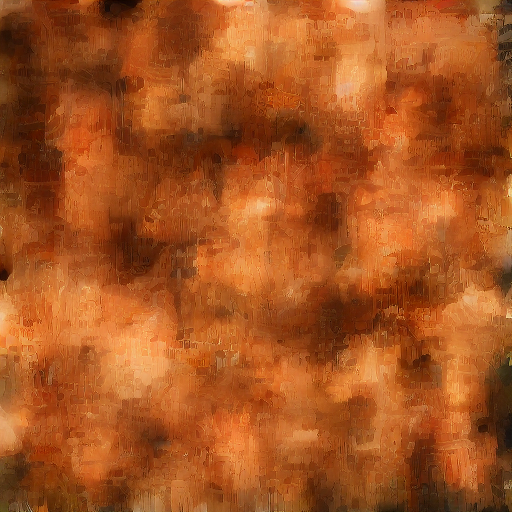

In [5]:
images = prompt_2_img(speaker_emb, save_int=False)
for img in images:display(img)